<a href="https://colab.research.google.com/github/Anirbit-AI/Expositions-With-PyTorch/blob/main/KdV_1_Soliton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consider the following KdV equation:
$$\frac{\partial u}{∂t} + \frac{∂^3u}{∂x^3} + 6u\frac{∂u}{∂x} = 0, (t,x)∈[0,1] × [0,1]$$
$$u(0, x) = u_0(x) = 2{\rm sech}^2(x-a), x∈[0,1]$$
$$u(t,x) = g(t,x) = 2{\rm sech}^2(x-4t-a), x ∈ \{0, 1\}$$

## 1.Setup

In [ ]:
# %%
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time
import copy
import pickle
import os

# %%
torch.set_default_tensor_type('torch.DoubleTensor')
# plt.style.use('seaborn-white')

## 2.Hyperparameter

Here ${\rm c}$ is the phase speed and ${\rm a}$ is an arbitary constant.
These are set up for more general KdV experiments, if we ever need.

In [ ]:
dimension = 2
input_width,layer_width = dimension, 30
width = layer_width

c = 4
a = 0

repeat = 2  # Editable
epoch1 =20000  # Editable
lr = 1e-4  # Editable
data_size = 500  # Editable
# create directory to save results
if not os.path.exists('data/KdV1_transformation'):
    os.makedirs('data/KdV1_transformation')

# create directory to save temporary results
if not os.path.exists('temp/KdV1_transformation'):
    os.makedirs('temp/KdV1_transformation')

# create directory to save images
if not os.path.exists('images/KdV1_transformation'):
    os.makedirs('images/KdV1_transformation')

## 3.Neural Architecture

In [ ]:
# %%
# activation function
def activation(x):
    return x * torch.sigmoid(x)


# %%
# build ResNet with one blocks
class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width):
        super(Net,self).__init__()
        self.layer1 = torch.nn.Linear(input_width, layer_width)
        self.layer2 = torch.nn.Linear(layer_width, layer_width)
        self.layer3 = torch.nn.Linear(layer_width, layer_width)
        self.layer4 = torch.nn.Linear(layer_width, 1)
        self.initialize_weights()
    def forward(self,x):
        y = activation(self.layer1(x))
        y = activation(self.layer3(activation(self.layer2(y)))) # residual block 1
        output = self.layer4(y)
        return output
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        # print(self)
        print('Total number of parameters: %d' % num_params)

${\rm N}(\vec{x}) := {\rm A}_{\rm 4}(σ{\rm A}_3({σ}{\rm A}_2({σ}{\rm A}_{\rm 1}(\vec{x}))))$, where

${\rm A}_1: \mathbb{R^2}{→}\mathbb{R}^{\rm 4}$, ${\rm A}_2: \mathbb{R}^{\rm 4}{→}\mathbb{R}^{\rm 4}$, ${\rm A}_3: \mathbb{R}^{\rm 4}{→}\mathbb{R}^{\rm 4}$, ${\rm A}_4: \mathbb{R}^{\rm 4}{→}\mathbb{R}$,

note: there are `57` parameters need to be trained in total in ${\rm N}(x)$

## 4.Training setup

### 4.1 Define the exact solution

$$[0,1]{×}[0,1]{\ni}(x, t) {↦} u(x, t) = 2sech^2(x-4t-{\rm a}) {∈} {\mathbb R}$$


In [ ]:
# defination of exact solution
def u_ex(X):
    x = X[:,0]
    t = X[:,1]

    temp1 = sqrt(c) * (x - c*t - a)/2
    u_temp = (1/2) * c * torch.square(torch.divide(1, torch.cosh(temp1)))
    return u_temp.reshape([x.size()[0], 1])

### 4.2 Define $u_0(x)$

$$ [0,1] {\ni} x {↦} u_0(x) = 2sech^2(x-a)∈ {\mathbb R} $$

In [ ]:
# Define u_0
def u_0x(X):

    x = X[:,0]
    temp1 = sqrt(c) * (x - a) / 2
    u_temp = (1/2) * c * torch.square(torch.divide(1, torch.cosh(temp1)))
    return u_temp.reshape([X.size()[0], 1])

### 4.3 Define g(x,t)

$$ \{0,1\}×[0,1] \ni (x,t) ↦ g(x,t) = 2sech^2(x-4t-a) ∈ {\mathbb R}$$

In [ ]:
def g_0x(X):
    x = torch.zeros([X.shape[0],1])[:,0]
    x.requires_grad = True
    t = X[:,1]
    # print(temp)
    temp1 = sqrt(c) * (x - c*t - a)/2
    u_temp = (1/2) * c * torch.square(torch.divide(1, torch.cosh(temp1)))
    return u_temp.reshape([x.size()[0], 1])

In [ ]:
def g_1x(X):
    x = torch.ones([X.shape[0],1])[:,0]
    x.requires_grad = True
    t = X[:,1]
    # print(temp)
    temp1 = sqrt(c) * (x - c*t - a)/2
    u_temp = (1/2) * c * torch.square(torch.divide(1, torch.cosh(temp1)))
    return u_temp.reshape([x.size()[0], 1])



### 4.4 Build the model (Train both on the boundary condition and initial condition)

$x = {\bf X}[:,0], t = {\bf X}[:,1]$


$${\rm model}({x,t}) := {\rm N}(x, t)$$





In [ ]:
def model1(X):
    term1 = net1(X)
    model_u_temp =  term1

    return model_u_temp.reshape([X.size()[0], 1])


### 4.5 Generate sample

#### 4.5.1 $ν_1$ generator

Generate random points $(x_n, t_n)$ from $[0,1] × [0,1]$

In [ ]:
# generate points by random
def generate_sample_one(data_size):
    sample_temp = torch.rand(data_size, dimension)
    sample_temp.requires_grad = True
    return sample_temp

#### 4.5.2 $ν_2$ generator

Generate random points $(x_n, t_n)$ from $\{0,1\} × [0,1]$

In [ ]:
def generate_sample_two(data_size):
    sample_temp = torch.rand(data_size, dimension)
    middle = int(data_size/2)
    sample_temp[:middle, 0] = 0
    sample_temp[middle:, 0] = 1
    sample_temp.requires_grad = True
    return sample_temp

#### 4.5.3 $ν_3$ generator

Generate random points $x_n$ from $[0,1]$

In [ ]:
def generate_sample_three(data_size):
    sample_temp = torch.rand(data_size, dimension)
    sample_temp[:,1] = 0
    sample_temp.requires_grad = True
    return sample_temp

### 4.6 Define Loss function


$${\rm Loss_1}(û) = \lVert{\frac{∂û}{∂t}} + {\frac{∂^3û}{∂x^3}} + 6u{\frac{∂û}{∂x}}\rVert^2_{[0,1]{×}{[0,1]},{ν_1}} + \lVert û-g(x) \rVert^2_{{\{0, 1\}}\times[0,1], ν_3} + \lVert û-u_0(x)\rVert^2_{[0,1], ν_3}$$




In [ ]:
# %%
def loss_function1(x1, x2, x3):
    # first term
    u_hat = model1(x1)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x1, grad_outputs = torch.ones(u_hat.shape), create_graph = True) # dx and dt
    dx = grad_u_hat[0][:, 0].reshape([len(grad_u_hat[0]), 1])  # dx
    dt = grad_u_hat[0][:, 1].reshape([len(grad_u_hat[0]), 1])  # dt
    dxx = torch.autograd.grad(outputs = dx, inputs = x1, grad_outputs = torch.ones(dx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxx
    dxxx = torch.autograd.grad(outputs = dxx, inputs = x1, grad_outputs = torch.ones(dxx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxxx
    loss = torch.sum((dt + dxxx + 6 * u_hat * dx)**2) / len(x1)

    # #second term
    u_hat2 = model1(x2)
    middle = int(int(data_size/2)/2)
    gx0 = g_0x(x2)[:middle]
    gx1 = g_1x(x2)[middle:]
    loss2 = torch.sum((u_hat2[:middle] - gx0)**2) / len(x2) + torch.sum((u_hat2[middle:] - gx1)**2) / len(x2)

    # third term
    u_hat3 = model1(x3)
    u0 = u_0x(x3)
    loss3 = torch.sum((u_hat3 - u0) **2) / len(x3)

    return loss + loss2 + loss3

### 4.7 Define Fractional Error

$${\rm error} = \frac{\lVert \hat u - u \lVert _2^2}{\lVert u \lVert_2^2}$$

In [ ]:
def cal_error1(x):
    u_hat = model1(x)
    u = u_ex(x)
    upper = torch.square((u_hat - u).norm(2))
    lower = torch.square(u.norm(2))
    return torch.divide(upper, lower)

## 5.Doing the training

### Generating training data and test data

In [ ]:
# Setting training data: 2*|datasize| in total (|datasize| from the space-time domain, |datasize/2| from the t=0 spatial slice, |datasize/2| from the x=0 and x=1 spatial slice)
x = generate_sample_one(data_size)
x2 = generate_sample_two(int(data_size/2))
x3 = generate_sample_three(int(data_size/2))

# Testing data
test_data = torch.zeros((101, 101, 2))
for i in range(101):
  x_test = i / 100
  for j in range(101):
    t_test = j / 100
    test_data[i][j][0] = x_test
    test_data[i][j][1] = t_test
test_data = torch.reshape(test_data, (101*101, 2))

### Training

In [ ]:
# %%
loss1_all = []
error1_all = []
u_hat_1_all = []
for t in range(repeat):
  print("Time: ", t+1, "/{}".format(repeat))

  net1 = Net(input_width,layer_width)
  optimizer1 = optim.Adam(net1.parameters(), lr=lr)

  loss_record1 = np.zeros(epoch1)
  error_record1 = np.zeros(epoch1)

  time_start = time.time()
  for i in range(1, epoch1+1):
      optimizer1.zero_grad()
      loss1 = loss_function1(x, x2, x3)
      error1 = cal_error1(test_data)
      loss_record1[i-1] = float(loss1)
      error_record1[i-1] = float(error1)
      loss1.backward()
      optimizer1.step()
      torch.cuda.empty_cache() # clear memory
      if i % 2000 == 0 or i == 1:
        print("current epoch: ", i)
        print("current loss: ", loss1.detach())
        print("current error: ", error1.detach())

  time_end = time.time()
  u_hat_1_all.append(model1(test_data).detach().numpy())
  loss1_all.append(loss_record1)
  error1_all.append(error_record1)
  print('total time is: ', time_end-time_start, 'seconds')

# save loss1_all, error1_all, u_hat_1_all using pickle
with open('data/KdV1_transformation/KdV1_loss1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(loss1_all, f)

with open('data/KdV1_transformation/KdV1_error1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(error1_all, f)

with open('data/KdV1_transformation/KdV1_u_hat_1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(u_hat_1_all, f)

Time:  1 /2
current epoch:  1
current loss:  tensor(3.5431)
current error:  tensor(1.0291)
current epoch:  2000
current loss:  tensor(0.3387)
current error:  tensor(0.1486)
current epoch:  4000
current loss:  tensor(0.3093)
current error:  tensor(0.1161)
current epoch:  6000
current loss:  tensor(0.2385)
current error:  tensor(0.0829)
current epoch:  8000
current loss:  tensor(0.0559)
current error:  tensor(0.0271)
current epoch:  10000
current loss:  tensor(0.0074)
current error:  tensor(0.0057)
current epoch:  12000
current loss:  tensor(0.0008)
current error:  tensor(0.0004)
current epoch:  14000
current loss:  tensor(0.0003)
current error:  tensor(0.0002)
current epoch:  16000
current loss:  tensor(0.0002)
current error:  tensor(0.0002)
current epoch:  18000
current loss:  tensor(0.0001)
current error:  tensor(0.0002)
current epoch:  20000
current loss:  tensor(0.0001)
current error:  tensor(0.0001)
total time is:  683.9676809310913 seconds
Time:  2 /2
current epoch:  1
current los

#### Load Data

In [ ]:

# load loss1_all, error1_all, u_hat_1_all using pickle
with open('/content/data/KdV1_transformation/KdV1_loss1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, width), 'rb') as f:
    loss1_all = pickle.load(f)

with open('/content/data/KdV1_transformation/KdV1_error1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, width), 'rb') as f:
    error1_all = pickle.load(f)

with open('/content/data/KdV1_transformation/KdV1_u_hat_1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, width), 'rb') as f:
    u_hat_1_all = pickle.load(f)

## 6.Plotting the output

### Plot the Exmperical Loss & Fractional Error

/tmp/ipython-input-130907040.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipython-input-130907040.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


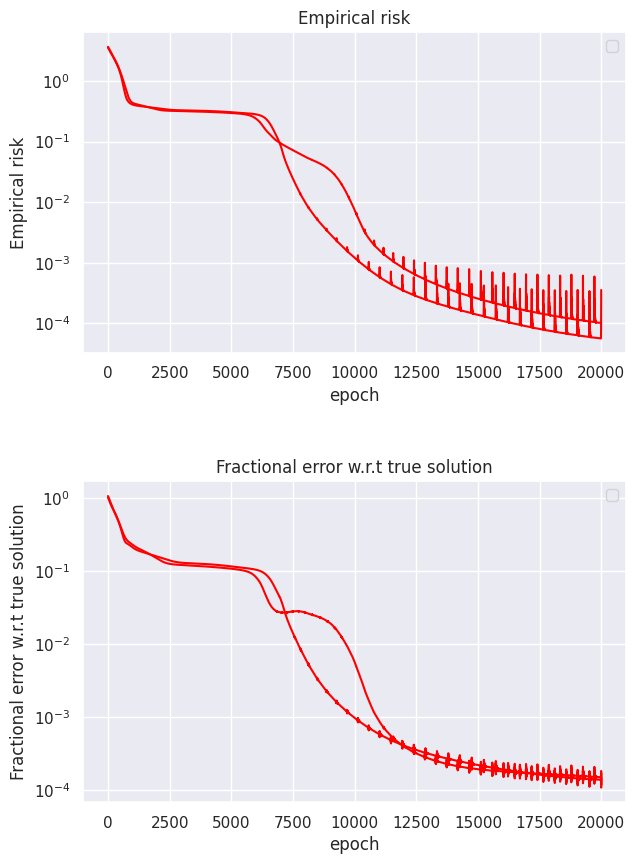

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(10)
fig.set_figwidth(7)

ax = fig.add_subplot(2, 1, 1)
for i in range(repeat):
    ax.plot(loss1_all[i], color = 'red')
ax.set_xlabel('epoch')
ax.set_ylabel('Empirical risk')
ax.set_title("Empirical risk")
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot(2, 1, 2)
for i in range(repeat):
    ax.plot(error1_all[i], color = 'red')
ax.set_xlabel('epoch')
ax.set_ylabel('Fractional error w.r.t true solution')
ax.set_title("Fractional error w.r.t true solution")
ax.set_yscale("log")
ax.legend()

# save the figure
fig.savefig('images/KdV1_transformation/KdV1_loss_error_{}_{}_{}_{}.png'.format(data_size*2, epoch1, lr, width))

### Plot the average of the loss and error

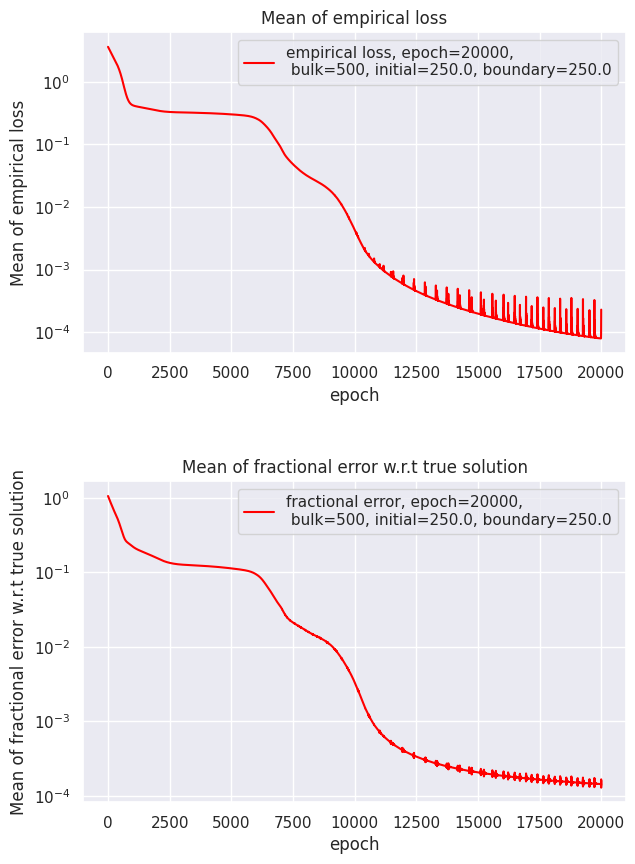

In [ ]:
# calculate the mean of loss1_all and error1_all in column direction
mean_loss1_all = np.array(loss1_all).mean(axis=0)
mean_error1_all = np.array(error1_all).mean(axis=0)


# Plot all the mean of loss and error
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(10)
fig.set_figwidth(7)

ax = fig.add_subplot(2, 1, 1)
ax.plot(mean_loss1_all, label = 'empirical loss, epoch={},\n bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
ax.set_xlabel('epoch')
ax.set_ylabel('Mean of empirical loss')
ax.set_title("Mean of empirical loss")
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot(2, 1, 2)
ax.plot(mean_error1_all, label = 'fractional error, epoch={},\n bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
ax.set_xlabel('epoch')
ax.set_ylabel('Mean of fractional error w.r.t true solution')
ax.set_title("Mean of fractional error w.r.t true solution")
ax.set_yscale("log")
ax.legend()

# save the figure
fig.savefig('images/KdV1_transformation/KdV1_loss_error_mean_{}_{}_{}_{}.png'.format(data_size*2, epoch1, lr, width))

### Plot the heat map Using 100 $\times$ 100 test data

In [ ]:
data_u_hat_1 = np.reshape(np.array(u_hat_1_all).mean(axis=0), (101,101))

data_u = np.reshape(u_ex(test_data), (101, 101)).detach().numpy()

# Generate x and y labels
x_axis_labels = []
y_axis_labels = []
for i in range(101):
  if i%10 == 0:
    x_axis_labels.append(i/100)
    y_axis_labels.append(i/100)
  else:
    x_axis_labels.append("")
    y_axis_labels.append("")

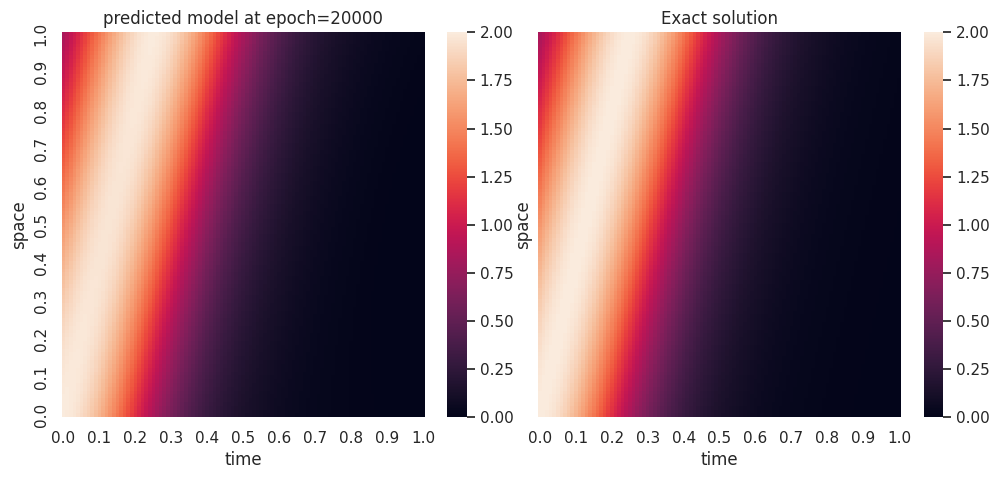

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,5)})

f, (ax1, ax2) = plt.subplots(1,2,sharey=True)
# set the subplot gap of the figure
fig.tight_layout()
plt.subplots_adjust(hspace=0.25, wspace=0.05)
# set font size
sns.set(font_scale=1)

g1 = sns.heatmap(data_u_hat_1, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=2, ax=ax1)
ax1.set_xlabel('time')
ax1.set_ylabel('space')
# reverse the y axis
ax1.invert_yaxis()
g1.set_title('predicted model at epoch='+str(epoch1))

g2 = sns.heatmap(data_u, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=2, ax=ax2)
ax2.set_xlabel('time')
ax2.set_ylabel('space')
ax2.invert_yaxis()
g2.set_title("Exact solution")

# save the figure
f.savefig("images/KdV1_transformation/KdV1_model_transformation_{}_{}.png".format(epoch1, width))

In [ ]:
# print the mean of loss and error for each model
print("The final average loss1 is {}".format(mean_loss1_all[-1]))
print("The final average error1 is {}".format(mean_error1_all[-1]))

The final average loss1 is 0.0002292525388854827
The final average error1 is 0.00016530459820099185
